In [1271]:
import numpy as np
import pickle
import numpy.matlib
import matplotlib.pyplot as plt
# didnt work ??? import functions.py.ipynb as f

# d = 3072
# k = 10
# n = 10000

In [1322]:
# Loades an entire batch
def LoadBatch(filename):
	""" Copied from the dataset website """ 
	with open('Datasets/'+filename, 'rb') as fo:
		dict = pickle.load(fo, encoding='bytes') 
	return dict

def softmax(x):
    """ Standard definition of the softmax function """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def ComputeGradsNumSlow(X, Y, P, W, b, lamda, h):
	""" Converted from matlab code """
	no 	= 	W.shape[0]
	d 	= 	X.shape[0]

	grad_W = np.zeros(W.shape);
	grad_b = np.zeros((no, 1));
	
	for i in range(len(b)):
		b_try = np.array(b)
		b_try[i] -= h
		c1 = ComputeCost(X, Y, W, b_try, lamda)

		b_try = np.array(b)
		b_try[i] += h
		c2 = ComputeCost(X, Y, W, b_try, lamda)

		grad_b[i] = (c2-c1) / (2*h)

	for i in range(W.shape[0]):
		for j in range(W.shape[1]):
			W_try = np.array(W)
			W_try[i,j] -= h
			c1 = ComputeCost(X, Y, W_try, b, lamda)

			W_try = np.array(W)
			W_try[i,j] += h
			c2 = ComputeCost(X, Y, W_try, b, lamda)

			grad_W[i,j] = (c2-c1) / (2*h)

	return [grad_W, grad_b]

##############################################################

def ReadData(filename):
    data_batch = LoadBatch(filename)
    
    # get pixel data
    # divide by 255 for single format
    # Maybe have to transpose
    pixel_data = data_batch[b'data'] #/255
    # labels for each image
    labels = data_batch[b'labels']
    # one-hot rep. of labels
    # T -> roterar
    one_hot = np.eye(10)[labels].T
    print(one_hot.shape)
    return pixel_data, one_hot, labels

def GetMeanAndStd(data):  
    print(data)
    # Kanske ändra
    mean = np.mean(data, 0)
    std = np.std(data, 0) # nånting saknas 
    return mean, std

# input trainings data mean std
def Normalize(train, validation, test, mean, std):
        # convert to floar
        train = np.float64(train)
        validation = np.float64(validation)
        test = np.float64(test)
        
        # Lurigt
        train -= mean 
        train /= std
    
        validation -= mean
        validation /= std
        
        test -= mean
        test /= std
        
        return train.T, validation.T, test.T
        
        #train = train    
def GetWeightAndBias(X, Y):
    W_size = np.shape(X)
    b_size = np.shape(Y)
    # Random seed????
    # loc = mean, scale = std
    np.random.seed(20)
    W = np.random.normal(loc=0.0, scale=0.01, size=(10, 3072))
    b = np.random.normal(loc=0.0, scale=0.01, size=(b_size[0], 1))
    
    return W, b


def EvaluateClassifier(X, W, b):
   # print(W.shape)
  #  print(X.shape)
    s = np.dot(W, X) + b
    # Softmax returns each probability for each class label
    P = softmax(s)
    return P

# 1. regularization term: calculate lambda * sum(W^2 ij)
# 2. sum it with l_cross + regularization term -> for each x,y in D
# 3. Multiply everything with 1 / length of D
def ComputeCost(X, Y, W, b, lambd):
    #div_D_length = 1 / len(X) * 2
   # print(div_D_length)

    # calculate P using softmax
    P = EvaluateClassifier(X, W, b)
    # Calculate cross-entropy-loss
    l_cross = -np.sum(np.multiply(Y, np.log(P)))
    # calculate regularization term
    reg_term = lambd * np.sum(np.square(W))
    # calculate total cost function
    
    # OBS: |D| is it the length of y+x or only x?
    J = (1 / len(X[1])) * l_cross + reg_term
    
    return J

def ComputeAccuracy(X, y, W, b):

    P = EvaluateClassifier(X,W,b)
    print("Output softmax: ", np.max(P))
    acc = np.mean(y == np.argmax(P, axis=0))
    
    return acc
    
# Tried to do from last slide of L3
# Forward pass is already done since we have already calculated P
def ComputeGradients(X, Y, P, W, lambd):

    n_b = X.shape[1]
    
    # Backward pass
    G_batch = -(Y - P)
    # Backward pass + reg term
    # LCROSS IS WHERE?! see (11) and (10)
    grad_W = 1 / n_b * np.dot(G_batch, X.T) + 2 * lambd * W
    # Backward pass for 
    grad_b = 1 / n_b * np.dot(G_batch, np.ones(shape=(n_b, 1)))
    return grad_W, grad_b

def CompareGradients(g_W, ng_W):
    abs_difference = np.sum(np.abs(g_W - ng_W))
    print("abs_difference", abs_difference)
    denominator = np.maximum(0.00001, np.sum(np.abs(g_W) + np.abs(ng_W)))
    print("denominator ", denominator)
    kvot = abs_difference / denominator
    print(kvot)

    if kvot < 1e-6:
        print("ok")
    else:
        print("gradient difference too high")

# Optimization of parameters with mini b GD
# Differs from Batch Gradient Descent and Stochastic GD
def MiniBatchGD(X, Y, GDparams, W, b, lambd):
    
    cost_list = []
    #W = 
    #b = 

    n_batch = GDparams['n_batch']
    epochs = GDparams['n_epochs']
    learning_rate = GDparams['eta']
   # print("X shape: ", X.shape)
   # print("b shape: ", b.shape)
   # print("W shape: ", W.shape)
    n = X.shape[1]
    for i in range(epochs):
        # Random subset of W
        # Random subset of 
        for j in range(n // n_batch):
            j_start = j*n_batch
            j_end = (j+1) * n_batch
            inds = range(j_start, j_end)
            # Random subset of train and corr. labels
            XBatch = X[:, inds]
            YBatch = Y[:, inds]
           # mini_W = W[:, inds]
           # mini_b = b[:, inds]
           # print("mini x shape: ", XBatch.shape)
           # print("mini y shape: ", YBatch.shape)
            P = EvaluateClassifier(XBatch, W, b)
            grad_W, grad_b = ComputeGradients(XBatch, YBatch, P, W, lambd)
            W_t1 = W - learning_rate * grad_W 
            b_t1 = b - learning_rate * grad_b
           # print(W_t1)
            cost_list.append(ComputeCost(XBatch, YBatch, W_t1, b_t1, lambd))
     
            
    return cost_list
            # Forward pass on mini batch
            
            # Make predictions om mb
            # Compute total cost of parameters
            
            # Backward pass on mini batch
            
            # Compute gradient
            
            # Now, update the parameters!

            # mini_W = W[:, inds]

            # print("mini_W, ", mini_W.shape)
            # gör nåt
            # gör nåt mer
            # predict?
            #
        # add cost per epoch
    


In [1323]:
# Read data
X_train, Y_train, y_test = ReadData('data_batch_1')
X_val_train, Y_val_train, y_val_test = ReadData('data_batch_2')
X_test_train, Y_test_train, y_test_test = ReadData('test_batch')

# Gets mean and std of training data
X_mean, X_std = GetMeanAndStd(X_train)

(10, 10000)
(10, 10000)
(10, 10000)
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]


In [1324]:
# Normalize all data w.r.t. mean and std of training data
X_train_normalized, X_val_train_normalized, X_test_train_normalized = Normalize(X_train, X_val_train, X_test_train, X_mean, X_std)

In [1325]:
# Create model params W and b
# W = Weight, b = bias
W, b = GetWeightAndBias(X_train_normalized, Y_train)

In [1326]:
# Model evaluation (take softmax)
P = EvaluateClassifier(X_train_normalized, W, b)

In [1327]:
# X = dxn array of images (columns)
# Y = 1xn vector of labels (in one-hot) for X
# J = scalar corresponing to sum of the loss of the network's predictions,
# in X relative to ground truth labels and reg. term on W (W= reg?). 
# Lambda = specifies how much penalty to be added 
J = ComputeCost(X_train_normalized, Y_train, W, b, lambd = 0.005)
print("Total cost: ", J)

Total cost:  2.414518623560972


In [1328]:
A = ComputeAccuracy(X_train_normalized, y_test, W, b)
print(A)

Output softmax:  0.6417714839467937
0.1116


In [1334]:
grad_W, grad_b = ComputeGradients(X_train_normalized[0:100, [1]], Y_train[:,[1]], P[0:100, [1]], W[:, 0:100], lambd=0)

In [1335]:
P_small = EvaluateClassifier(X_train_normalized[0:20, [1]], W[:, 0:20], b)
ngrad_W, ngrad_b = ComputeGradsNumSlow(X_train_normalized[0:20, [1]], Y_train[:,[1]], P_small, W[:, 0:20], b, 0, 1e-6)
                                                

In [1336]:
CompareGradients(grad_W, ngrad_W)

ValueError: operands could not be broadcast together with shapes (10,100) (10,20) 

In [1337]:
GDparams = {'n_batch': 100, 'eta': 0.001, 'n_epochs': 20}

#W_star, b_star = 
cost = MiniBatchGD(X_train_normalized,  Y_train, GDparams, W, b, 0)
print(cost)

[2.3694959932329227, 2.3516489148501556, 2.3376344553719757, 2.281907760440912, 2.3115216961095477, 2.348925600704266, 2.333323482085352, 2.3462566288085713, 2.386255761885314, 2.368470787322938, 2.3494282329394274, 2.3328653585419006, 2.2418882884669817, 2.3916339302729233, 2.3400703484211403, 2.308338003566835, 2.297399258840754, 2.3728338310816612, 2.300172185286945, 2.340722675242192, 2.3648379303819285, 2.2940150256813188, 2.3664992283339696, 2.3428463981009022, 2.2992669186966723, 2.3896325197176953, 2.2797047908129096, 2.314162675955673, 2.3313585441327, 2.392014695174479, 2.2905683948297444, 2.348051201925947, 2.374447896356484, 2.3714922353361856, 2.4241877805679803, 2.393937873012124, 2.3811394737580747, 2.3921444567125283, 2.372721626762299, 2.3102840735192816, 2.4665799457197046, 2.371843735577129, 2.2459370863588193, 2.372093583247804, 2.426587107503889, 2.212678517535962, 2.3021155562783906, 2.401809358192842, 2.2691844378066044, 2.3540245287487696, 2.343399599604968, 2.3

Text(0.5, 1.0, 'Error vs. Training Epoch')

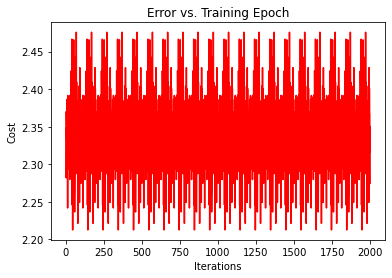

In [1340]:
fig, ax = plt.subplots()  
ax.plot(np.arange(GDparams['n_epochs']), cost, 'r')  
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Epoch')